In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 15000
stock = '9061'

In [3]:
d, d_cv, d_test = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/prepared', cv=True, length=data_length)

In [4]:
d.head()
d_test.head()

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
0,2013-09-02 09:00:00,"[(550.0, 6364.0), (630.0, 15016.0), (631.0, 18...","[(688.6, 4298.0), (688.7, 9651.0), (688.8, 151...",688.3,688.6,688.45,4298.0,3388.0,1.0,-0.118397
1,2013-09-02 09:01:00,"[(550.0, 6364.0), (630.0, 15016.0), (631.0, 18...","[(688.8, 6637.0), (688.9, 14116.0), (689.0, 12...",688.5,688.8,688.65,6637.0,2560.0,1.0,-0.443297
2,2013-09-02 09:02:00,"[(550.0, 6364.0), (630.0, 15016.0), (631.0, 18...","[(689.4, 2985.0), (689.5, 12252.0), (689.6, 46...",689.0,689.4,689.20,2985.0,5934.0,1.0,0.330642
3,2013-09-02 09:03:00,"[(550.0, 6364.0), (630.0, 15016.0), (631.0, 18...","[(689.5, 1900.0), (689.6, 18368.0), (689.7, 29...",689.4,689.5,689.45,1900.0,3289.0,0.0,0.267682
4,2013-09-02 09:04:00,"[(550.0, 6364.0), (630.0, 15016.0), (631.0, 18...","[(689.2, 2630.0), (689.3, 20130.0), (689.4, 15...",688.9,689.2,689.05,2630.0,12319.0,0.0,0.648137


In [5]:
## Data visualization

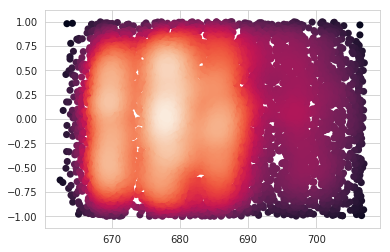

<Figure size 432x288 with 0 Axes>

In [6]:
lob.plot_density_imbalance_vs_mid(d, 0, len(d))

## Logistic

0.5307947671852575

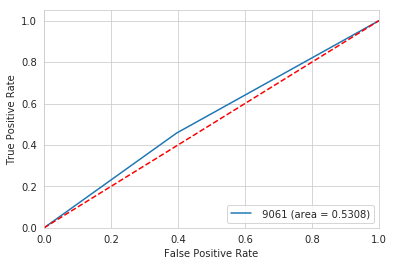

In [7]:
log_clf = lob.logistic_regression(d, 0, len(d))
pred = log_clf.predict(d_test['queue_imbalance'].values.reshape(-1, 1))
lob.plot_roc(d_test, log_clf, stock=stock, label='')

## SVM

In [8]:
gammas = [0.0005, 0.005, 1, 5, 50, 500, 5000]
cs = [0.0005, 0.005, 1, 5.0, 50, 500, 1000]
coef0s = [0, 0.0005, 0.005, 1, 5, 50, 500, 5000]

try:
    df_svm_res = pd.read_csv('res_svm_{}_{}.csv'.format(stock, data_length))
    print('Results read from file')
except FileNotFoundError:
    print('Results file does not exist yet')
    df_svm_res = pd.DataFrame(columns=['svm', 'c', 'gamma', 'coef0', 'roc_cv_score', 'roc_train_score'])
s = stock
svm_results = []
for c in cs:
    for g in gammas:
        for coef0 in coef0s:
            if np.any(df_svm_res[df_svm_res['c'] 
                             == c][df_svm_res['gamma'] == g][df_svm_res['coef0'] 
                                                             == coef0][df_svm_res['svm'] =='sigmoid']):
                continue
            
            svm = lob_svm.SVMSigmoid(s, d, c=c, coef0=coef0, gamma=g, data_length=data_length)
            cv_score = svm.predict(d_cv, 'cv', check=False)
            train_score = svm.predict(d, 'train', check=False)
            svm_results.append({'svm': 'sigmoid', 'c': c, 'coef0': coef0, 'gamma': g, 
                                'roc_cv_score': cv_score, 'roc_train_score': train_score})
        if np.any(df_svm_res[df_svm_res['c'] == c][df_svm_res['gamma'] == g][df_svm_res['svm'] =='rbf']):
            continue
        svm = lob_svm.SVMRbf(s, d, c=c, gamma=g, data_length=data_length)
        cv_score = svm.predict(d_cv, 'cv', check=False)
        train_score = svm.predict(d, 'train', check=False)
        svm_results.append({'svm': 'rbf', 'c': c, 'gamma': g, 
                            'roc_cv_score': cv_score, 'roc_train_score': train_score})
    if np.any(df_svm_res[df_svm_res['c'] == c][df_svm_res['svm'] =='linear']):
        continue
    svm = lob_svm.SVMLinear(s, d, c=c, data_length=data_length)
    cv_score = svm.predict(d_cv, 'cv', check=False)
    train_score = svm.predict(d, 'train', check=False)
    svm_results.append({'svm': 'linear', 'c': c, 'roc_cv_score': cv_score, 'roc_train_score': train_score})
    pd.DataFrame(svm_results).to_csv('res_svm_{}_{}.csv'.format(stock, data_length))
for svm_result in svm_results:
    df_svm_res = df_svm_res.append(svm_result, ignore_index=True)
    df_svm_res.drop(columns=[c for c in df_svm_res.columns if 'Unnamed:' in c], inplace=True)
df_svm_res.sort_values(by='roc_cv_score', ascending=False)
df_svm_res.head()

Results read from file


,Unnamed: 0,svm,c,gamma,coef0,roc_cv_score,roc_train_score
0,0,sigmoid,0.0005,0.0005,0.0000,0.5,0.5
1,1,sigmoid,0.0005,0.0005,0.0005,0.5,0.5
2,2,sigmoid,0.0005,0.0005,0.0050,0.5,0.5
3,3,sigmoid,0.0005,0.0005,1.0000,0.5,0.5
4,4,sigmoid,0.0005,0.0005,5.0000,0.5,0.5


In [9]:
df_svm_res.to_csv('res_svm_{}_{}.csv'.format(stock, data_length))
df_svm_res.sort_values(by='roc_cv_score')

,Unnamed: 0,svm,c,gamma,coef0,roc_cv_score,roc_train_score
183,183,sigmoid,1.000,5000.0000,0.0005,0.471522,0.464751
182,182,sigmoid,1.000,5000.0000,0.0000,0.471522,0.464751
184,184,sigmoid,1.000,5000.0000,0.0050,0.471854,0.464641
103,103,sigmoid,0.005,50.0000,1.0000,0.473283,0.465735
185,185,sigmoid,1.000,5000.0000,1.0000,0.484269,0.467857
102,102,sigmoid,0.005,50.0000,0.0050,0.486098,0.466599
101,101,sigmoid,0.005,50.0000,0.0005,0.486098,0.466710
100,100,sigmoid,0.005,50.0000,0.0000,0.486098,0.466710
159,159,sigmoid,1.000,5.0000,5.0000,0.487354,0.495823
223,223,sigmoid,5.000,5.0000,5.0000,0.487738,0.494320


## GDF

In [10]:
K = 50

def gdf_svm_classification(df, K, C=1000, gamma=1):
    clf = SVC(kernel='rbf', C=C, gamma=gamma)
    gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
    X = df.loc[:, gdf_columns]
    y = df['mid_price_indicator'].values.reshape(-1, 1)
    y[0] = 0
    clf.fit(X, y)
    return clf

length = data_length
rr = [0.01, 0.05, 0.1, 0.5, 1]
ss = [0.01, 0.05, 0.1, 0.5, 1]
results = []

try:
    df_gdf_res = pd.read_csv('res_gdf_svm_{}_{}.csv'.format(stock,data_length))
    print('Results read from file')
except FileNotFoundError:
    print('Results file does not exist yet')
    df_gdf_res = pd.DataFrame(columns=['svm', 'c', 'gamma', 'roc_cv_score', 'roc_train_score',
                                          'K', 'r', 's'])


for r in rr:
    for s in ss:

        filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(stock, length, r, s, K)
        dfs, dfs_cv, dfs_test = lob.load_prepared_data(
            filename, data_dir='../gaussian_filter/data_gdf/', cv=True, length=length)
        gdf_columns = ['gdf_' + str(i) for i in range(0, K)]

        for C in [1, 10, 100, 1000, 10000]:
            for gamma in [1, 10, 100, 1000, 10000]:
                res = {}
                res['c'] = C
                res['gamma'] = gamma
                res['r'] = r
                res['s'] = s
                res['stock'] = stock
                res['K'] = K
                res['svm'] = 'rbf'
                if np.any(df_gdf_res[df_gdf_res['c'] 
                             == C][df_gdf_res['gamma'] 
                                   == gamma][df_gdf_res['r'] 
                                             == r][df_gdf_res['s'] 
                                                   == s][df_gdf_res['K'] 
                                                         == K][df_gdf_res['svm'] == 'rbf']):
                    continue
                

                clf = gdf_svm_classification(dfs, K, C=C, gamma=gamma)
                predictions = clf.predict(dfs.loc[:, gdf_columns])
                try:
                    roc_train = roc_auc_score(predictions, dfs['mid_price_indicator'])
                    res['roc_train_score'] = roc_train
                except Exception as e:
                    print(e, r, s, C, gamma)
                predictions = clf.predict(dfs_cv.loc[:, gdf_columns])
                try:
                    roc_cv = roc_auc_score(predictions, dfs_cv['mid_price_indicator'])
                    res['roc_cv_score'] = roc_cv
                except Exception as e:
                    print(e, r, s, C, gamma)
                results.append(res)
                pd.DataFrame(results).to_csv('res_gdf_svm_{}_{}.csv'.format(stock, data_length))
for result in results:
    df_gdf_res = df_gdf_res.append(result, ignore_index=True)
    df_gdf_res.drop(columns=[c for c in df_gdf_res.columns if 'Unnamed:' in c], inplace=True)


Results file does not exist yet


FileNotFoundError: File b'../gaussian_filter/data_gdf/gdf_9061_len15000_r0.01_s0.01_K50.csv' does not exist

In [ ]:
df_gdf_res.to_csv('res_gdf_svm_{}_{}.csv'.format(stock, data_length))

In [ ]:
a = df_gdf_res[df_gdf_res['r'] == 0.1].sort_values(by='roc_cv_score', ascending=False).sort_values(by='s')
a[['s', 'roc_train_score', 'roc_cv_score']].plot(kind='bar', figsize=(16,16))

## GDF with logistic reg

In [ ]:
K = 50

def gdf_log_classification(df, K, C=1000):
    gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
    clf = LogisticRegression(C=C)
    X = df.loc[:, gdf_columns]
    y = df['mid_price_indicator'].values.reshape(-1, 1)
    y[0] = 0
    clf.fit(X, y)
    return clf

length = data_length
rr = [0.01, 0.05, 0.1, 0.5, 1]
ss = [0.01, 0.05, 0.1, 0.5, 1]
results = []

try:
    df_gdf_log_res = pd.read_csv('res_gdf_log_{}_{}.csv'.format(stock, data_length))
    print('Results read from file')
except FileNotFoundError:
    print('Results file does not exist yet')
    df_gdf_log_res = pd.DataFrame(columns=['c', 'roc_cv_score', 'roc_train_score', 'K', 'r', 's'])

for r in rr:
    for s in ss:

        filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(stock, length, r, s, K)
        dfs, dfs_cv, dfs_test = lob.load_prepared_data(
            filename, data_dir='../gaussian_filter/data_gdf/', cv=True, length=length)
        gdf_columns = ['gdf_' + str(i) for i in range(0, K)]

        for C in [1, 10, 100, 1000, 10000]:
            res = {}
            res['c'] = C
            res['r'] = r
            res['s'] = s
            res['stock'] = stock
            res['K'] = K
            if np.any(df_gdf_log_res[df_gdf_log_res['c'] 
                         == C][df_gdf_log_res['r'] == r][df_gdf_log_res['s'] == s][df_gdf_log_res['K'] == K]):
                continue

            clf = gdf_log_classification(dfs, K, C=C)
            predictions = clf.predict(dfs.loc[:, gdf_columns])
            try:
                roc_train = roc_auc_score(predictions, dfs['mid_price_indicator'])
                res['roc_train_score'] = roc_train
            except Exception as e:
                print(e, r, s, C, gamma)
            predictions = clf.predict(dfs_cv.loc[:, gdf_columns])
            try:
                roc_cv = roc_auc_score(predictions, dfs_cv['mid_price_indicator'])
                res['roc_cv_score'] = roc_cv
            except Exception as e:
                print(e, r, s, C, gamma)
            results.append(res)
            pd.DataFrame(results).to_csv('res_gdf_log_{}_{}.csv'.format(stock, data_length))
for result in results:
    df_gdf_log_res = df_gdf_log_res.append(result, ignore_index=True)
    df_gdf_log_res.drop(columns=[c for c in df_gdf_log_res.columns if 'Unnamed:' in c], inplace=True)


In [ ]:
df_gdf_log_res.to_csv('res_gdf_log_{}_{}.csv'.format(stock, data_length))

In [ ]:
df_gdf_log_res.sort_values(by='roc_cv_score', ascending=False).head(5)

In [ ]:
df_gdf_res.sort_values(by='roc_cv_score', ascending=False).head(5)

## Results on test

In [ ]:
best_gdf_res = df_gdf_res.sort_values(by='roc_cv_score', ascending=False).iloc[0]
best_gdf_log_res = df_gdf_log_res.sort_values(by='roc_cv_score', ascending=False).iloc[0]
best_svm_sig_res = df_svm_res[df_svm_res['svm'] == 'sigmoid'].sort_values(
    by='roc_cv_score', ascending=False).iloc[0]
best_svm_rbf_res = df_svm_res[df_svm_res['svm'] == 'rbf'].sort_values(
    by='roc_cv_score', ascending=False).iloc[0]          
best_svm_lin_res = df_svm_res[df_svm_res['svm'] == 'linear'].sort_values(
    by='roc_cv_score', ascending=False).iloc[0]
res_dict = OrderedDict({
    'gdf_svm': best_gdf_res,
    'gdf_log': best_gdf_log_res,
    'svm_rbf': best_svm_rbf_res,
    'svm_lin': best_svm_lin_res,
    'svm_sig': best_svm_sig_res,
})

In [ ]:
plt.bar(list(range(len(res_dict.keys()))), [v['roc_cv_score'] for v in res_dict.values()],)
d = plt.xticks(list(range(len(res_dict.keys()))), list(res_dict.keys()))
plt.title('CV score')
for k, v in res_dict.items():
    print(k, v['roc_cv_score'])

In [ ]:
plt.bar(list(range(len(res_dict.keys()))), [v['roc_train_score'] for v in res_dict.values()],)
d = plt.xticks(list(range(len(res_dict.keys()))), list(res_dict.keys()))
plt.title('train score')
for k, v in res_dict.items():
    print(k, v['roc_train_score'])

In [ ]:
list(res_dict.values())[0]

In [ ]:
filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(stock, length, best_gdf_res['r'], best_gdf_res['s'], 
                                             int(best_gdf_res['K']))
dfs, dfs_cv, dfs_test = lob.load_prepared_data(
    filename, data_dir='../gaussian_filter/data_gdf/', cv=True, length=length)
svm_gdf_clf = gdf_svm_classification(dfs, K, C=best_gdf_res['c'], gamma=best_gdf_res['gamma'])
gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
pred_test = svm_gdf_clf.predict(dfs_test.loc[:, gdf_columns])
roc_test = roc_auc_score(pred_test, dfs_test['mid_price_indicator'])
best_gdf_res['roc_test_score'] = roc_test
roc_test

In [ ]:
filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(
    stock, length, best_gdf_log_res['r'], best_gdf_log_res['s'], int(best_gdf_log_res['K']))
dfs, dfs_cv, dfs_test = lob.load_prepared_data(
    filename, data_dir='../gaussian_filter/data_gdf/', cv=True, length=length)
svm_gdf_clf = gdf_log_classification(dfs, K, C=best_gdf_res['c'])
gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
pred_test = svm_gdf_clf.predict(dfs_test.loc[:, gdf_columns])
roc_test = roc_auc_score(pred_test, dfs_test['mid_price_indicator'])
best_gdf_log_res['roc_test_score'] = roc_test
roc_test

In [ ]:
d, d_cv, d_test = lob.load_prepared_data(stock, 
                                         data_dir='../queue_imbalance/data/prepared', cv=True, length=10000)

svm = lob_svm.SVMRbf(stock, d, c=best_svm_rbf_res['c'], gamma=best_svm_rbf_res['gamma'], data_length=data_length)
roc_test = svm.predict(d_test, 'test', check=False)
best_svm_rbf_res['roc_test_score'] = roc_test

svm = lob_svm.SVMSigmoid(stock, d, c=best_svm_sig_res['c'], 
                         gamma=best_svm_sig_res['gamma'], coef0=best_svm_sig_res['coef0'])
roc_test = svm.predict(d_test, 'test', check=False)
best_svm_sig_res['roc_test_score'] = roc_test

svm = lob_svm.SVMLinear(stock, d, c=best_svm_lin_res['c'])
roc_test = svm.predict(d_test, 'test', check=False)
best_svm_lin_res['roc_test_score'] = roc_test

In [ ]:

plt.bar(list(range(len(res_dict.keys()))), [v['roc_train_score'] for v in res_dict.values()])
plt.bar(list(range(len(res_dict.keys()))), [v['roc_test_score'] for v in res_dict.values()])

d = plt.xticks(list(range(len(res_dict.keys()))), list(res_dict.keys()))
plt.title('test score')
for k, v in res_dict.items():
    print(k, v['roc_test_score'])

In [ ]:
res = []
for k, v in res_dict.items():
    dd = v.to_dict()
    dd['type'] = k
    res.append(dd)
df_res = pd.DataFrame(res)

df_res[['roc_train_score', 'roc_cv_score', 'roc_test_score']].plot(kind='bar', figsize=(8, 8))
d = plt.xticks(list(range(len(res_dict.keys()))), list(res_dict.keys()))
plt.legend(loc='upper right')